## **Data Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# ===============================
# 1. Load Dataset
# ===============================
fore_df = pd.read_csv(r'D:\DATA ANALYST-DATA SCIENTIST\MY PROJECT 2025\MARKETING FILE\P2\Dataset_1.csv')
janji_df = pd.read_csv(r'D:\DATA ANALYST-DATA SCIENTIST\MY PROJECT 2025\MARKETING FILE\P2\Dataset_2.csv')

# Tambahkan kolom brand
fore_df['brand'] = 'Fore Coffee'
janji_df['brand'] = 'Janji Jiwa'

# Gabungkan dataset
df = pd.concat([fore_df, janji_df], ignore_index=True)

# ===============================
# 2. Pilih kolom yang dibutuhkan
# ===============================
columns_needed = [
    'authorMeta/fans', 'authorMeta/name', 'collectCount',
    'commentCount', 'createTimeISO', 'diggCount', 'isSponsored',
    'locationMeta/city', 'locationMeta/locationName', 'shareCount',
    'text', 'videoMeta/duration', 'webVideoUrl', 'playCount', 'brand'
]
df = df[columns_needed].copy()

# Pastikan format tanggal benar
df['createTimeISO'] = pd.to_datetime(df['createTimeISO'], errors='coerce')

# ===============================
# 3. Hapus duplikat berdasarkan createTimeISO
# ===============================
print(f"Jumlah data sebelum hapus duplikat: {df.shape[0]}")
df = df.drop_duplicates(subset='createTimeISO', keep='first')
print(f"Jumlah data setelah hapus duplikat: {df.shape[0]}")

# ===============================
# 4. Tangani Missing Values
# ===============================
numeric_cols = ['authorMeta/fans', 'collectCount', 'commentCount',
                'diggCount', 'shareCount', 'videoMeta/duration', 'playCount']

# Numerik isi median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Tanggal isi modus (paling sering muncul)
if df['createTimeISO'].isnull().sum() > 0:
    most_common_time = df['createTimeISO'].mode()[0]
    df['createTimeISO'] = df['createTimeISO'].fillna(most_common_time)

# Kategorikal isi 'Unknown' atau modus
df['authorMeta/name'] = df['authorMeta/name'].fillna('Unknown')
df['locationMeta/city'] = df['locationMeta/city'].fillna('Unknown')
df['locationMeta/locationName'] = df['locationMeta/locationName'].fillna('Unknown')
df['isSponsored'] = df['isSponsored'].fillna(df['isSponsored'].mode()[0])

# Text & URL isi kosong
df['text'] = df['text'].fillna('')
df['webVideoUrl'] = df['webVideoUrl'].fillna('')

# ===============================
# 5. Tangani Outlier dengan IQR
# ===============================
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] >= lower) & (dataframe[column] <= upper)]

for col in numeric_cols:
    before = df.shape[0]
    df = remove_outliers_iqr(df, col)
    after = df.shape[0]
    print(f"Outlier dibersihkan di {col}: {before - after} baris dihapus")

# ===============================
# 6. Feature Engineering waktu
# ===============================
df['hour'] = df['createTimeISO'].dt.hour
df['day'] = df['createTimeISO'].dt.day_name()

# ===============================
# 7. Cek hasil akhir
# ===============================
print("\nSetelah pembersihan:")
print(f"Total data: {df.shape[0]}")
print("Missing values:\n", df.isnull().sum())

# ===============================
# 8. (Opsional) Simpan dataset bersih
# ===============================
df.to_csv(r'D:\DATA ANALYST-DATA SCIENTIST\MY PROJECT 2025\MARKETING FILE\P2\Dataset_Bersih.csv', index=False)
print("\nDataset bersih berhasil disimpan.")

Jumlah data sebelum hapus duplikat: 1066
Jumlah data setelah hapus duplikat: 913
Outlier dibersihkan di authorMeta/fans: 122 baris dihapus
Outlier dibersihkan di collectCount: 135 baris dihapus
Outlier dibersihkan di commentCount: 66 baris dihapus
Outlier dibersihkan di diggCount: 56 baris dihapus
Outlier dibersihkan di shareCount: 57 baris dihapus
Outlier dibersihkan di videoMeta/duration: 40 baris dihapus
Outlier dibersihkan di playCount: 62 baris dihapus

Setelah pembersihan:
Total data: 375
Missing values:
 authorMeta/fans              0
authorMeta/name              0
collectCount                 0
commentCount                 0
createTimeISO                0
diggCount                    0
isSponsored                  0
locationMeta/city            0
locationMeta/locationName    0
shareCount                   0
text                         0
videoMeta/duration           0
webVideoUrl                  0
playCount                    0
brand                        0
hour              

C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\2331842264.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isSponsored'] = df['isSponsored'].fillna(df['isSponsored'].mode()[0])


In [2]:
import pandas as pd

# === 1. Baca Data Asli ===
file_path = r"D:\DATA ANALYST-DATA SCIENTIST\MY PROJECT 2025\MARKETING FILE\P2\Dataset_Bersih.csv"
df = pd.read_csv(file_path)

# === 2. Pilih Kolom yang Dipakai ===
selected_cols = [
    'authorMeta/fans', 'authorMeta/name', 'collectCount',
    'commentCount', 'createTimeISO', 'diggCount', 'isSponsored',
    'locationMeta/city', 'locationMeta/locationName', 'shareCount',
    'text', 'videoMeta/duration', 'webVideoUrl', 'playCount', 'brand'
]
df = df[selected_cols]

# Buang data kosong
df = df.dropna(subset=['brand', 'playCount', 'collectCount', 'diggCount'])

# === 3. Cek Jumlah & Persentase Sebelum Balancing ===
before_counts = df['brand'].value_counts()
before_percent = df['brand'].value_counts(normalize=True) * 100

# === 4. Balancing Data (Undersampling) ===
min_count = df['brand'].value_counts().min()
df_balanced = df.groupby('brand').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# === 5. Cek Jumlah & Persentase Sesudah Balancing ===
after_counts = df_balanced['brand'].value_counts()
after_percent = df_balanced['brand'].value_counts(normalize=True) * 100

# === 6. Gabungkan ke Tabel Perbandingan ===
comparison_df = pd.DataFrame({
    'Jumlah Data Sebelum': before_counts,
    'Persentase Sebelum (%)': before_percent.round(1),
    'Jumlah Data Sesudah': after_counts,
    'Persentase Sesudah (%)': after_percent.round(1)
})

print("\n📊 Perbandingan Jumlah Data Sebelum & Sesudah Balancing:")
print(comparison_df)

# === 7. Simpan data seimbang ===
output_path = "dataset_balanced.csv"
df_balanced.to_csv(output_path, index=False)
print(f"\n✅ Data seimbang disimpan sebagai {output_path}")



📊 Perbandingan Jumlah Data Sebelum & Sesudah Balancing:
             Jumlah Data Sebelum  Persentase Sebelum (%)  Jumlah Data Sesudah  \
brand                                                                           
Fore Coffee                  126                    33.6                  126   
Janji Jiwa                   249                    66.4                  126   

             Persentase Sesudah (%)  
brand                                
Fore Coffee                    50.0  
Janji Jiwa                     50.0  

✅ Data seimbang disimpan sebagai dataset_balanced.csv


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\1422118620.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('brand').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


## **Exploratory Data Analysis - EDA**

,hour_idn,mean,median,webVideoUrl
0,Pukul 13.00,57900.0,57900.0,Link Video
1,Pukul 14.00,29800.0,29800.0,Link Video
2,Pukul 02.00,28400.0,28400.0,Link Video
3,Pukul 04.00,23900.0,23900.0,Link Video
4,Pukul 11.00,18500.0,18500.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')


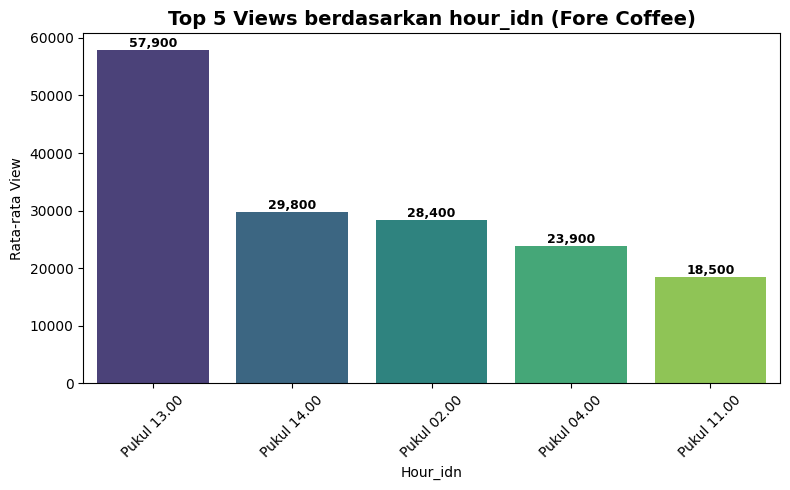

,day,mean,median,webVideoUrl
0,Senin,57900.0,57900.0,Link Video
1,Kamis,29800.0,29800.0,Link Video
2,Senin,28400.0,28400.0,Link Video
3,Selasa,23900.0,23900.0,Link Video
4,Senin,18500.0,18500.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')


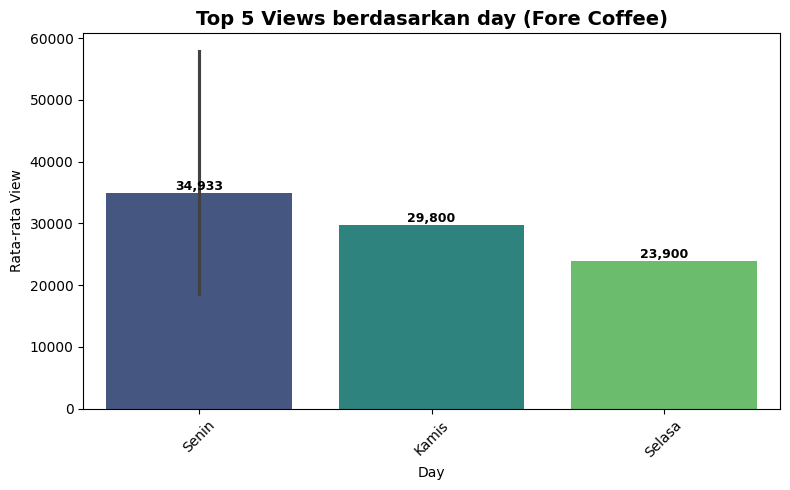

,username,mean,median,webVideoUrl
0,weldyarf,57900.0,57900.0,Link Video
1,hotchaleck,29800.0,29800.0,Link Video
2,foresthreecoffeeofficial,28400.0,28400.0,Link Video
3,claudiofernandi,23900.0,23900.0,Link Video
4,forecoffee.id,18500.0,18500.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')


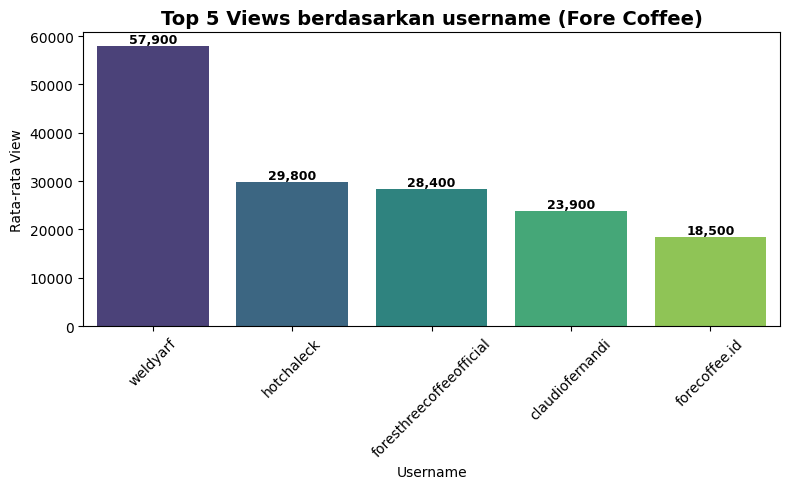

,location,mean,median,webVideoUrl
0,Fore Coffee - Bendungan Hilir,57900.0,57900.0,Link Video
1,"Fore Coffee, Bandung Indah Plaza",29800.0,29800.0,Link Video
2,"Foresthree Coffee & Kitchen, Cilandak",28400.0,28400.0,Link Video
3,Unknown,23900.0,23900.0,Link Video
4,Unknown,18500.0,18500.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')


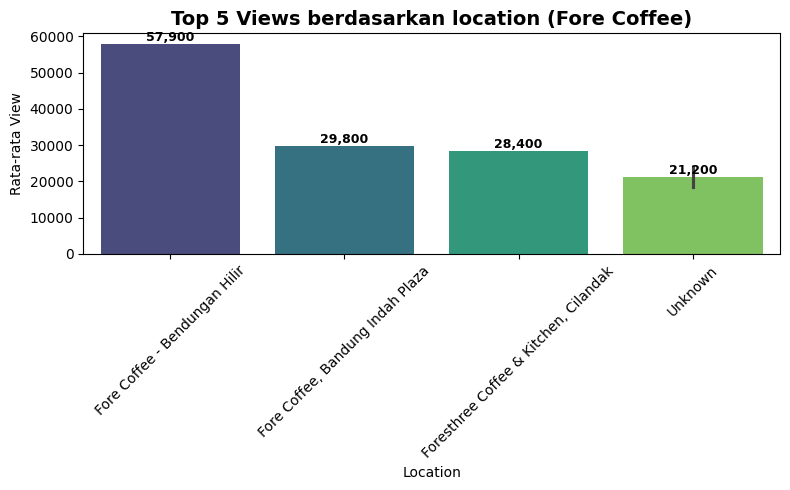

,hour_idn,mean,median,webVideoUrl
0,Pukul 02.00,55700.0,55700.0,Link Video
1,Pukul 03.00,51400.0,51400.0,Link Video
2,Pukul 03.00,48500.0,48500.0,Link Video
3,Pukul 08.00,43300.0,43300.0,Link Video
4,Pukul 01.00,40700.0,40700.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')


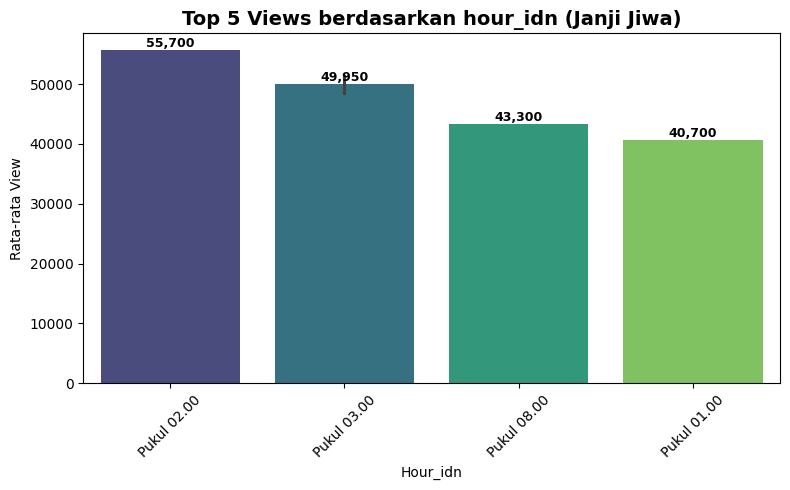

,day,mean,median,webVideoUrl
0,Minggu,55700.0,55700.0,Link Video
1,Selasa,51400.0,51400.0,Link Video
2,Senin,48500.0,48500.0,Link Video
3,Selasa,43300.0,43300.0,Link Video
4,Minggu,40700.0,40700.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')


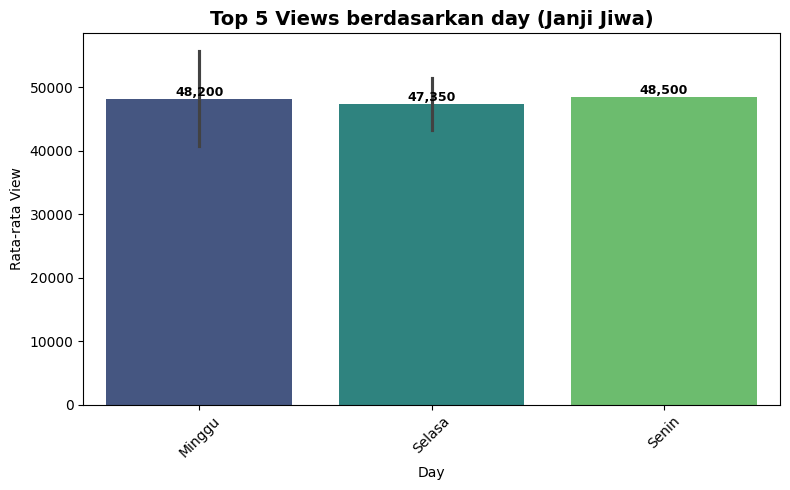

,username,mean,median,webVideoUrl
0,kevinsikokobandung,55700.0,55700.0,Link Video
1,bu_diinnn,51400.0,51400.0,Link Video
2,rajajualannih,48500.0,48500.0,Link Video
3,oreyosoftcake,43300.0,43300.0,Link Video
4,teyaeee,40700.0,40700.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')


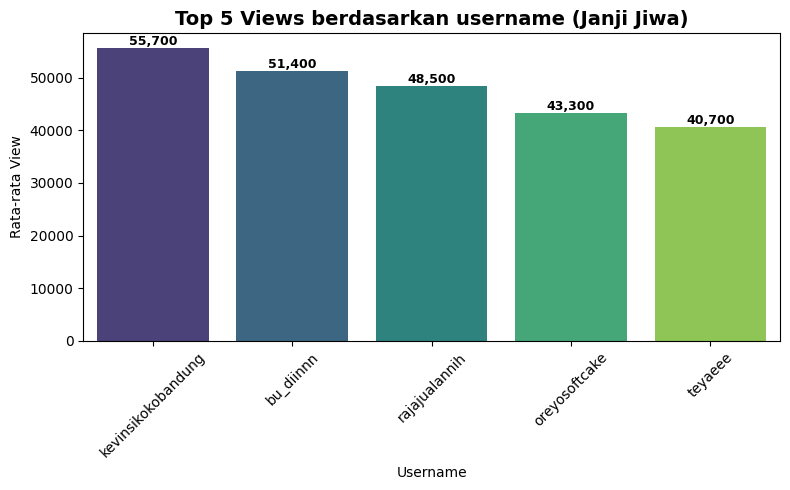

,location,mean,median,webVideoUrl
0,Kopi Janji Jiwa & Jiwa Toast - Ruko Icon BSD,55700.0,55700.0,Link Video
1,Kopi Janji Jiwa & Jiwa Toast - Ruko Taman Kota Kuningan,51400.0,51400.0,Link Video
2,Kopi Janji Jiwa & Jiwa Toast - Grage Mall Cirebon,48500.0,48500.0,Link Video
3,Kopi Janji Jiwa & Jiwa Toast - Hayam Wuruk Purwodadi,43300.0,43300.0,Link Video
4,Kopi Janji Jiwa & Jiwa Toast - Ruko Mayjen Soetoyo Purworejo,40700.0,40700.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')


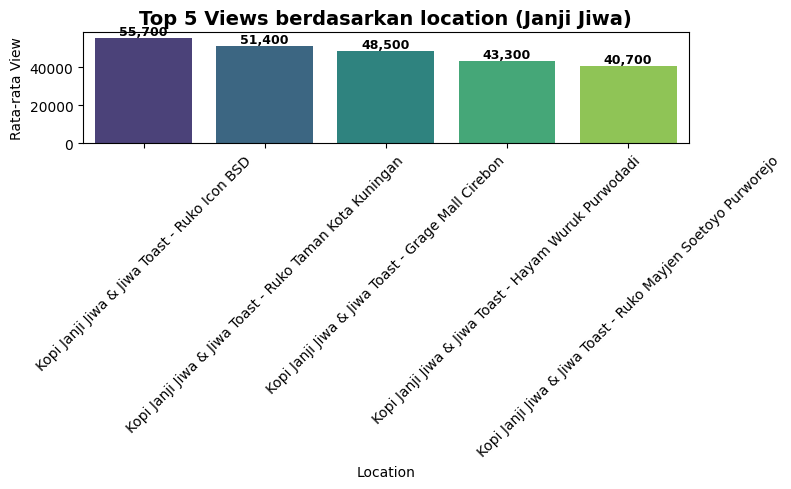

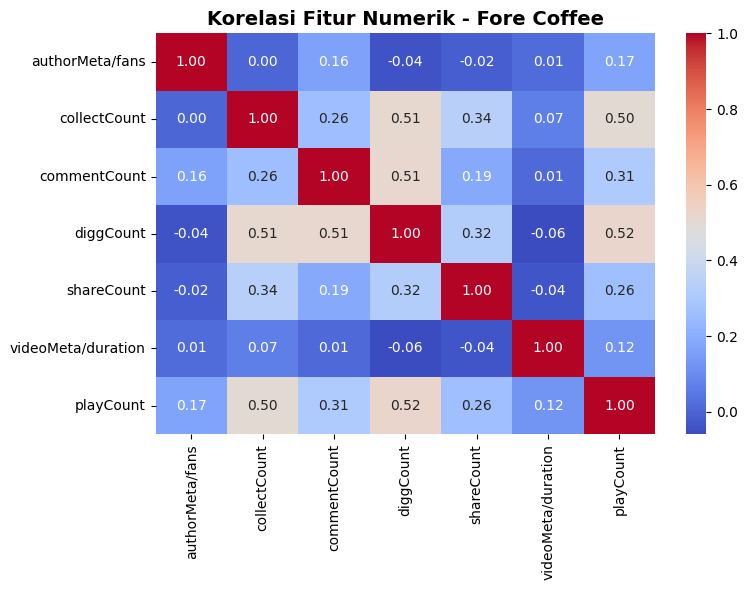

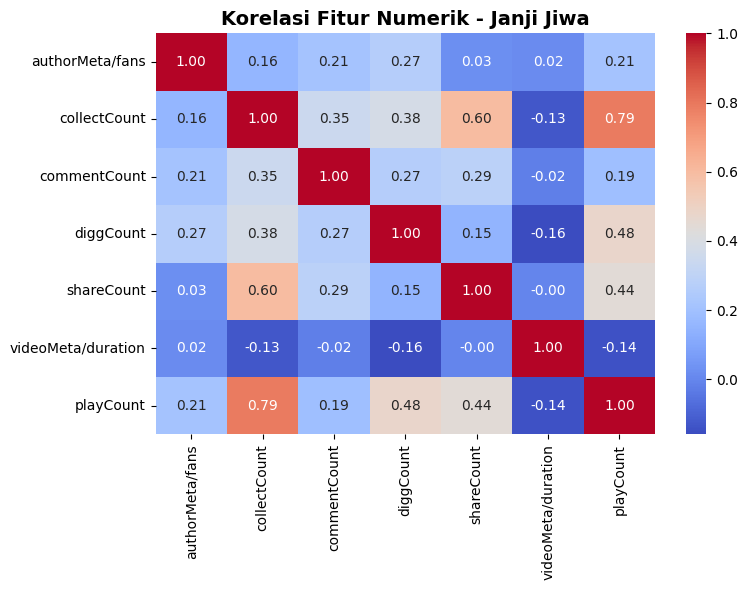

,username,mean,median,webVideoUrl
0,plateby.plate1,114.0,114.0,Link Video
1,forecoffeesg,65.0,65.0,Link Video
2,foresthreerawalumbu,63.0,63.0,Link Video
3,hotchaleck,46.0,46.0,Link Video
4,essenwe,45.0,45.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='username', y='mean', data=save_top, palette='plasma')


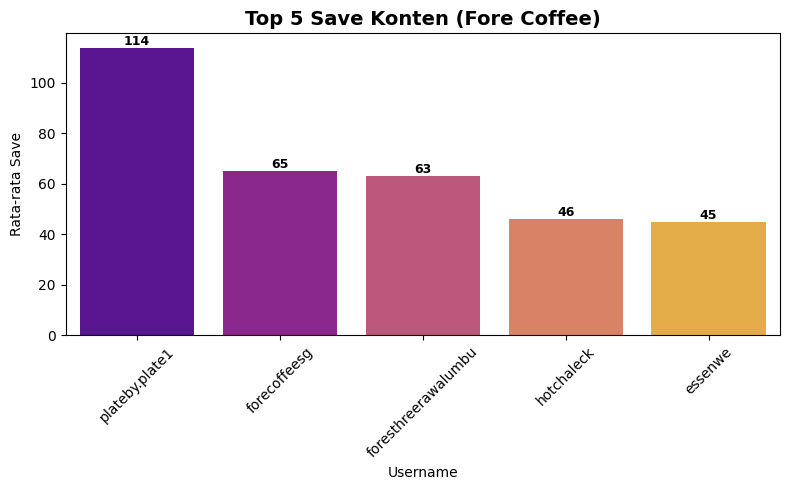

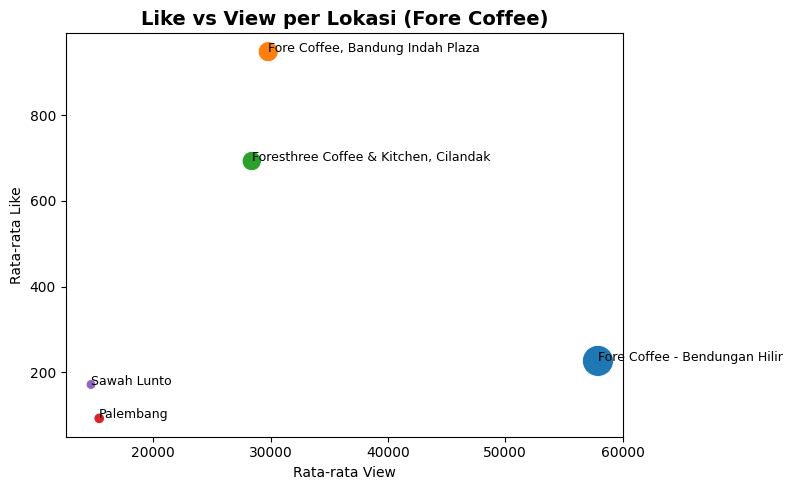

,username,mean,median,webVideoUrl
0,oreyosoftcake,63.0,63.0,Link Video
1,cindy_sinora,47.0,47.0,Link Video
2,kalemhyrruph,46.0,46.0,Link Video
3,bu_diinnn,46.0,46.0,Link Video
4,ayangjajan,42.0,42.0,Link Video


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\513503596.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='username', y='mean', data=save_top, palette='plasma')


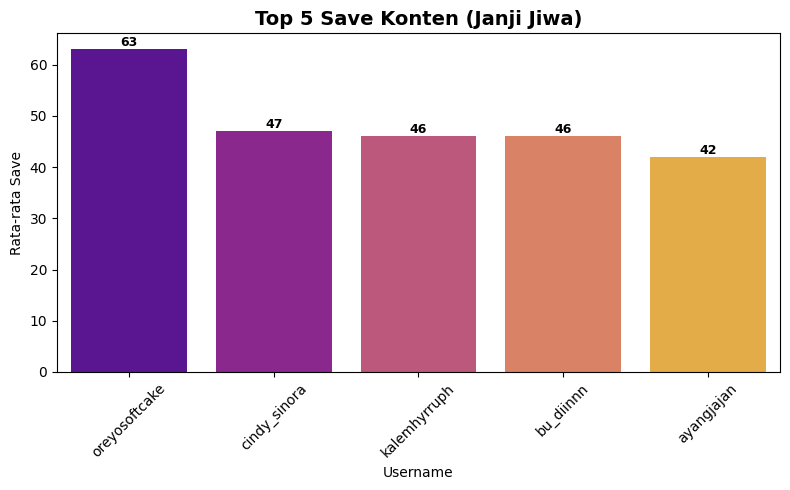

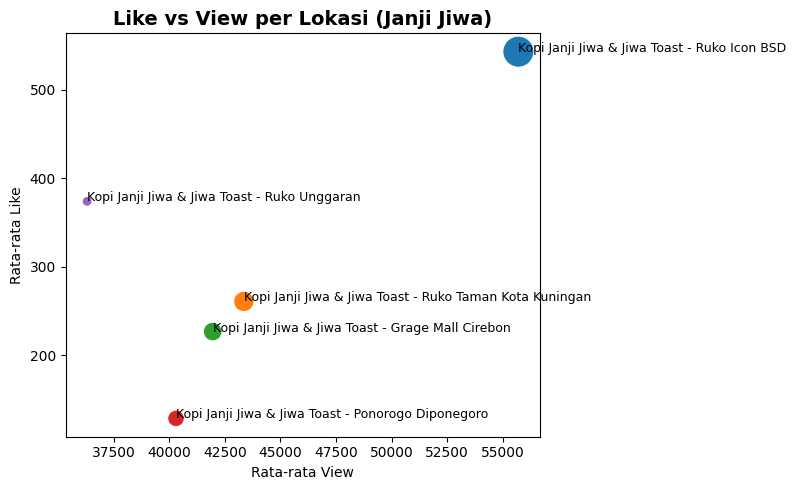

In [3]:
from IPython.display import HTML, display

# === 1. Baca dataset ===
df = pd.read_csv(r"D:\DATA ANALYST-DATA SCIENTIST\MY PROJECT 2025\MARKETING FILE\P2\dataset_balanced.csv")

# Pastikan kolom waktu menjadi datetime
df['createTimeISO'] = pd.to_datetime(df['createTimeISO'], errors='coerce')

# Mapping hari ke bahasa Indonesia
day_map = {
    "Monday": "Senin",
    "Tuesday": "Selasa",
    "Wednesday": "Rabu",
    "Thursday": "Kamis",
    "Friday": "Jumat",
    "Saturday": "Sabtu",
    "Sunday": "Minggu"
}

# Ekstrak hari & jam
df['day'] = df['createTimeISO'].dt.day_name().map(day_map)
df['hour'] = df['createTimeISO'].dt.hour
df['hour_idn'] = df['hour'].apply(lambda x: f"Pukul {x:02d}.00")

# Rename kolom biar mudah
df.rename(columns={
    'authorMeta/name': 'username',
    'locationMeta/locationName': 'location'
}, inplace=True)

# Pastikan semua link punya prefix https://
df['webVideoUrl'] = df['webVideoUrl'].apply(
    lambda x: x if str(x).startswith('http') else f"https://www.tiktok.com{x}"
)

# Fungsi buat HTML link
def make_clickable(url):
    return f'<a href="{url}" target="_blank">Link Video</a>'

# === 2. Top 5 view berdasarkan jam, hari, username, lokasi ===
def top5_views_per_group(df, group_col, brand):
    result = df[df['brand'] == brand].groupby([group_col, 'webVideoUrl'])['playCount'].agg(
        mean='mean',
        median='median'
    ).sort_values(by='mean', ascending=False).head(5).reset_index()
    return result

brands = df['brand'].unique()

# Visualisasi Top 5 Views
for brand in brands:
    for col in ['hour_idn', 'day', 'username', 'location']:
        top5_df = top5_views_per_group(df, col, brand)
        
        # Buat link klik-able
        top5_df['webVideoUrl'] = top5_df['webVideoUrl'].apply(make_clickable)
        display(HTML(top5_df[[col, 'mean', 'median', 'webVideoUrl']].to_html(escape=False)))
        
        plt.figure(figsize=(8,5))
        ax = sns.barplot(x=col, y='mean', data=top5_df, palette='viridis')
        plt.title(f"Top 5 Views berdasarkan {col} ({brand})", fontsize=14, fontweight='bold')
        plt.ylabel("Rata-rata View")
        plt.xlabel(col.capitalize())
        plt.xticks(rotation=45)
        
        for p in ax.patches:
            ax.annotate(f'{p.get_height():,.0f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom',
                        fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# === 3. Korelasi antar fitur numerik ===
numeric_cols = [
    'authorMeta/fans', 'collectCount', 'commentCount', 
    'diggCount', 'shareCount', 'videoMeta/duration', 'playCount'
]

for brand in brands:
    corr = df[df['brand'] == brand][numeric_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Korelasi Fitur Numerik - {brand}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# === 4. Top 5 Save (collectCount), Like vs View, dan Lokasi ===
def top5_save_and_like_vs_view(df, brand):
    data_brand = df[df['brand'] == brand]
    
    # Top 5 Save
    top5_save = data_brand.groupby(['username', 'webVideoUrl'])['collectCount'].agg(
        mean='mean',
        median='median'
    ).sort_values(by='mean', ascending=False).head(5).reset_index()
    
    # Buat link klik-able
    top5_save['webVideoUrl'] = top5_save['webVideoUrl'].apply(make_clickable)
    
    # Like vs View per lokasi
    like_vs_view = data_brand.groupby('location').agg({
        'diggCount': ['mean', 'median'],
        'playCount': ['mean', 'median']
    }).sort_values(('playCount','mean'), ascending=False).head(5)
    like_vs_view.columns = ['Like Mean', 'Like Median', 'View Mean', 'View Median']
    like_vs_view = like_vs_view.reset_index()
    
    return top5_save, like_vs_view

# Visualisasi Save & Like vs View
for brand in brands:
    save_top, like_view_top = top5_save_and_like_vs_view(df, brand)
    
    display(HTML(save_top[['username', 'mean', 'median', 'webVideoUrl']].to_html(escape=False)))
    
    # Bar chart Top Save
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x='username', y='mean', data=save_top, palette='plasma')
    plt.title(f"Top 5 Save Konten ({brand})", fontsize=14, fontweight='bold')
    plt.ylabel("Rata-rata Save")
    plt.xlabel("Username")
    plt.xticks(rotation=45)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Scatter plot Like vs View
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x='View Mean', y='Like Mean', 
        size='View Mean', hue='location', 
        data=like_view_top, sizes=(50, 500), palette='tab10', legend=False
    )
    for i in range(len(like_view_top)):
        plt.text(
            like_view_top['View Mean'][i],
            like_view_top['Like Mean'][i],
            like_view_top['location'][i],
            fontsize=9
        )
    plt.title(f"Like vs View per Lokasi ({brand})", fontsize=14, fontweight='bold')
    plt.xlabel("Rata-rata View")
    plt.ylabel("Rata-rata Like")
    plt.tight_layout()
    plt.show()


In [4]:
df.columns

Index(['authorMeta/fans', 'username', 'collectCount', 'commentCount',
       'createTimeISO', 'diggCount', 'isSponsored', 'locationMeta/city',
       'location', 'shareCount', 'text', 'videoMeta/duration', 'webVideoUrl',
       'playCount', 'brand', 'day', 'hour', 'hour_idn'],
      dtype='object')

## **Encoding**

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Baca dataset
df = pd.read_csv("D:\DATA ANALYST-DATA SCIENTIST\MY PROJECT 2025\MARKETING FILE\P2\dataset_balanced.csv")

# Format Tanggal & Ekstraksi Waktu
df['createTimeISO'] = pd.to_datetime(df['createTimeISO'], errors='coerce')
df['tanggal'] = df['createTimeISO'].dt.date
df['jam'] = df['createTimeISO'].dt.hour

# Mapping hari Inggris ke Indonesia
hari_map = {
    'Monday': 'Senin', 'Tuesday': 'Selasa', 'Wednesday': 'Rabu',
    'Thursday': 'Kamis', 'Friday': 'Jumat', 'Saturday': 'Sabtu', 'Sunday': 'Minggu'
}
df['day'] = df['createTimeISO'].dt.day_name().map(hari_map)
df['hour'] = df['createTimeISO'].dt.hour
df['hour_idn'] = df['hour']

# Bersihkan kolom isSponsored
df['isSponsored'] = df['isSponsored'].map({'False': False, 'True': True})
df['isSponsored'] = df['isSponsored'].fillna(False).astype(int)

# Tangani nilai unknown
df['locationMeta/city'] = df['locationMeta/city'].replace('unknown', pd.NA)
df['locationMeta/locationName'] = df['locationMeta/locationName'].replace('unknown', pd.NA)

# Encoding ordinal hari
hari_ordinal = {
    'Senin': 1, 'Selasa': 2, 'Rabu': 3,
    'Kamis': 4, 'Jumat': 5, 'Sabtu': 6, 'Minggu': 7
}
df['hari_encoded'] = df['day'].map(hari_ordinal)

# One-Hot Encoding Kota
df = pd.get_dummies(df, columns=['locationMeta/city'], prefix='kota', dummy_na=True)

# Label Encoding Username
le_user = LabelEncoder()
df['username_encoded'] = le_user.fit_transform(df['authorMeta/name'].astype(str))

# Encoding Brand Fore Coffee dan Janji Jiwa
df['brand_encoded'] = df['brand'].map({'Fore Coffee': 0, 'Janji Jiwa': 1}).fillna(2).astype(int)

# Pastikan kolom sesuai target
kolom_target = [
    'authorMeta/fans', 'authorMeta/name', 'collectCount', 'commentCount',
    'createTimeISO', 'diggCount', 'isSponsored', 'locationMeta/locationName',
    'location', 'shareCount', 'text', 'videoMeta/duration', 'webVideoUrl',
    'playCount', 'brand', 'brand_encoded', 'day', 'hour', 'hour_idn', 'tanggal',
    'hari_encoded', 'username_encoded'
] + [col for col in df.columns if col.startswith('kota_')]

kolom_final = [col for col in kolom_target if col in df.columns]
df_encoded = df[kolom_final]

# Simpan hasil encode ke CSV baru
output_path = 'encoded.csv'
df_encoded.to_csv(output_path, index=False)

print(f"Hasil encoding sudah disimpan di: {output_path}")


Hasil encoding sudah disimpan di: encoded.csv


C:\Users\yogib\AppData\Local\Temp\ipykernel_5272\684814457.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isSponsored'] = df['isSponsored'].fillna(False).astype(int)


In [6]:
df.columns

Index(['authorMeta/fans', 'authorMeta/name', 'collectCount', 'commentCount',
       'createTimeISO', 'diggCount', 'isSponsored',
       'locationMeta/locationName', 'shareCount', 'text', 'videoMeta/duration',
       'webVideoUrl', 'playCount', 'brand', 'tanggal', 'jam', 'day', 'hour',
       'hour_idn', 'hari_encoded', 'kota_Ada', 'kota_Ambon',
       'kota_Bandung City', 'kota_Bandung Regency', 'kota_Banggai Regency',
       'kota_Banjarmasin', 'kota_Banyumas Regency', 'kota_Batam',
       'kota_Bekasi City', 'kota_Bekasi Regency', 'kota_Blora',
       'kota_Bogor Regency', 'kota_Cianjur', 'kota_Cilacap', 'kota_Cilegon',
       'kota_Cimahi', 'kota_Cirebon', 'kota_Cirebon City',
       'kota_Deli Serdang Regency', 'kota_Denpasar City', 'kota_Depok',
       'kota_East Kotawaringin Regency', 'kota_Fontana', 'kota_Fremantle',
       'kota_Gowa Regency', 'kota_Grand Bay', 'kota_Grobogan Regency',
       'kota_Irving', 'kota_Jakarta', 'kota_Jambi City', 'kota_Jeddah',
       'kota_Jember',

## **MODELING DAN EVALUASI**

In [7]:
# ================================
# 0. Import Library
# ================================

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import cloudpickle

# ================================
# 1. Load Data
# ================================
df = pd.read_csv(r"D:\DATA ANALYST-DATA SCIENTIST\MY PROJECT 2025\MARKETING FILE\P2\encoded.csv")

# Hapus kolom yang tidak dibutuhkan
drop_cols = ['authorMeta/name', 'text', 'createTimeISO', 'webVideoUrl']
df.drop(columns=drop_cols, errors='ignore', inplace=True)
df.dropna(inplace=True)

# ================================
# 2. Feature Engineering
# ================================
df['likes_per_follower'] = df['diggCount'] / (df['authorMeta/fans'] + 1)
df['comments_per_like'] = df['commentCount'] / (df['diggCount'] + 1)
df['plays_per_follower'] = df['playCount'] / (df['authorMeta/fans'] + 1)

# ================================
# 3. Persiapan Fitur dan Target
# ================================
target_cols = ['playCount', 'collectCount', 'diggCount']
X = df.drop(columns=target_cols)
y = df[target_cols]
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
y_test = np.expm1(y_test_log)  # untuk evaluasi

# ================================
# 4. Preprocessing Pipeline
# ================================
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# ================================
# 5. GridSearchCV untuk LightGBM
# ================================
print("\n🔧 Tuning LightGBM...")

param_grid = {
    'regressor__estimator__n_estimators': [100, 200],
    'regressor__estimator__max_depth': [3, 5, 10],
    'regressor__estimator__learning_rate': [0.05, 0.1]
}

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(LGBMRegressor(random_state=42)))
])

grid_search = GridSearchCV(lgbm_pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train_log)

best_lgbm = grid_search.best_estimator_
print("✅ Best LightGBM params:", grid_search.best_params_)

# Prediksi dan evaluasi
y_pred_log_lgbm = best_lgbm.predict(X_test)
y_pred_lgbm = np.expm1(y_pred_log_lgbm)

print("\n📊 [LightGBM - Tuned]")
for i, col in enumerate(target_cols):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_lgbm[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred_lgbm[:, i])
    print(f"{col} — MAE: {mae:.2f}, R²: {r2:.4f}")


# ================================
# 7. Simpan Model Terbaik
# ================================
print("\n💾 Menyimpan model terbaik (LightGBM)...")
with open("best_model_tuned.pkl", "wb") as f:
    cloudpickle.dump(best_lgbm, f)

print("✅ Model terbaik berhasil disimpan ke 'best_model_tuned.pkl'")



🔧 Tuning LightGBM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best LightGBM params: {'regressor__estimator__learning_rate': 0.1, 'regressor__estimator__max_depth': 5, 'regressor__estimator__n_estimators': 100}

📊 [LightGBM - Tuned]
playCount — MAE: 3215.31, R²: 0.7532
collectCount — MAE: 5.31, R²: 0.5152
diggCount — MAE: 47.88, R²: 0.6075

💾 Menyimpan model terbaik (LightGBM)...
✅ Model terbaik berhasil disimpan ke 'best_model_tuned.pkl'
